## TASK

The aim of the project is to compare accuracy of forecasts of prices of two cointegrated financial
instruments with VECM model and two independent univariate ARIMA models.
- Find one cointegrated pair out of ten provided time series. There is more than one cointegrated
pair but you are supposed to find just one of them. If you found more than one pair, you can
choose any of them for further analysis.
- Build a bivariate VECM model for the identified pair and produce forecasts of prices of two
instruments for the out-of-sample period.
- Find separately for two instruments the most attractive univariate ARIMA models and produce
forecasts for the same out-of-sample period.
- Compare accuracy of forecasts of the prices using the ex-post forecast error measures.
- Prepare a short report on it.

In [2]:
# Libraries

import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from src.utils import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR, VECM
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.api import OLS
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')



## Data

Given csv file with prices series for 10 different assets we need to find cointegrated pairs and choose one for the further analysis. We begin our analysis with visual inspection of the series.

Recall that two series are cointegrated if both of them are $I(n)$, so integrated of order $n$, but some linear relationship of those series is $I(n-1)$, for $n \geq 1$. 

With financial series we most often deal with series $I(1)$ and $I(0)$, so we expect to find 2 nonstationary series whose linear combination is stationary. Visually we expect that the difference between those series is fluctuating around some mean value with time. This is because:
$$
Y_t - \beta X_t = Z_t
$$
where $X_t$ and $Y_t$ are cointegrated series and $Z_t$ is stationary. As $Z_t$ is stationary, thus has constant mean over time, we should expect difference between $Y_t$ and $X_t$ fluctuating around some mean value.

In [3]:
# Loading the data
df = pd.read_csv('../data/prices.csv')

In [4]:
df.head()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
0,2023-09-09,109.41,109.41,109.41,124.24,124.47,109.41,119.94,104.66,107.62,119.32
1,2023-09-10,109.41,109.41,109.41,124.21,124.32,109.41,101.39,104.34,102.61,119.36
2,2023-09-11,109.42,109.41,109.41,124.41,124.37,109.41,97.64,104.23,99.16,119.38
3,2023-09-12,108.68,110.19,111.12,123.93,124.82,109.41,94.35,107.23,103.39,121.06
4,2023-09-13,106.21,110.88,112.92,122.68,123.91,107.84,96.22,109.71,102.43,122.17


In [5]:
df.tail()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
595,2025-04-26,236.25,157.43,98.53,187.42,104.92,70.59,38.88,86.80,136.49,215.32
596,2025-04-27,235.26,159.66,100.24,187.09,104.51,69.54,30.55,89.88,131.38,220.03
597,2025-04-28,235.07,162.04,102.27,187.40,104.03,68.72,38.72,93.09,129.86,224.60
598,2025-04-29,234.99,164.39,103.17,186.88,103.34,67.41,44.01,94.24,128.16,229.31
599,2025-04-30,234.70,167.05,105.45,186.76,102.90,66.36,53.75,98.26,132.49,234.87


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    600 non-null    object 
 1   y1      600 non-null    float64
 2   y2      600 non-null    float64
 3   y3      600 non-null    float64
 4   y4      600 non-null    float64
 5   y5      600 non-null    float64
 6   y6      600 non-null    float64
 7   y7      600 non-null    float64
 8   y8      600 non-null    float64
 9   y9      600 non-null    float64
 10  y10     600 non-null    float64
dtypes: float64(10), object(1)
memory usage: 51.7+ KB


We can see above that the date column in our data is of object type representing string. It is recommended to work with dates as datetime objects set as index of the dateframe. So we change type of the data contained in date column to datetime and set the column as index.

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    600 non-null    datetime64[ns]
 1   y1      600 non-null    float64       
 2   y2      600 non-null    float64       
 3   y3      600 non-null    float64       
 4   y4      600 non-null    float64       
 5   y5      600 non-null    float64       
 6   y6      600 non-null    float64       
 7   y7      600 non-null    float64       
 8   y8      600 non-null    float64       
 9   y9      600 non-null    float64       
 10  y10     600 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 51.7 KB


In [8]:
df.set_index('date', inplace = True)
df.head()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
date,,,,,,,,,,
2023-09-09,109.41,109.41,109.41,124.24,124.47,109.41,119.94,104.66,107.62,119.32
2023-09-10,109.41,109.41,109.41,124.21,124.32,109.41,101.39,104.34,102.61,119.36
2023-09-11,109.42,109.41,109.41,124.41,124.37,109.41,97.64,104.23,99.16,119.38
2023-09-12,108.68,110.19,111.12,123.93,124.82,109.41,94.35,107.23,103.39,121.06
2023-09-13,106.21,110.88,112.92,122.68,123.91,107.84,96.22,109.71,102.43,122.17


In [9]:
# Split data
sample_df = df.iloc[:575]
test_df = df.iloc[575:]
sample_df.tail()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
date,,,,,,,,,,
2025-04-01,224.12,166.00,82.20,181.88,112.36,85.41,67.08,60.90,161.17,232.59
2025-04-02,222.07,165.75,82.16,180.99,112.84,86.48,63.81,61.00,164.55,232.09
2025-04-03,219.19,164.16,81.66,179.85,113.13,87.45,61.44,60.19,166.98,228.88
2025-04-04,215.87,163.47,82.28,177.80,112.74,85.95,64.40,60.62,165.29,227.57
2025-04-05,213.66,162.05,82.90,176.79,112.85,85.84,68.93,61.68,164.04,224.79


Now we can proceed with visual inspection and cointegration testing. 

---

## Testing for cointegration

### Visual analysis

As we shown above we should expect difference between cointegrated series to fluctuate around some mean value. Starting from the top the behavior is clear for orange and ligth blue lines, so for y2 and y10 series. But while testing for cointegration with Engle&Granger test showed that both series are cointegrated, the Johansen test showed us that there is perfect colinearity (?).

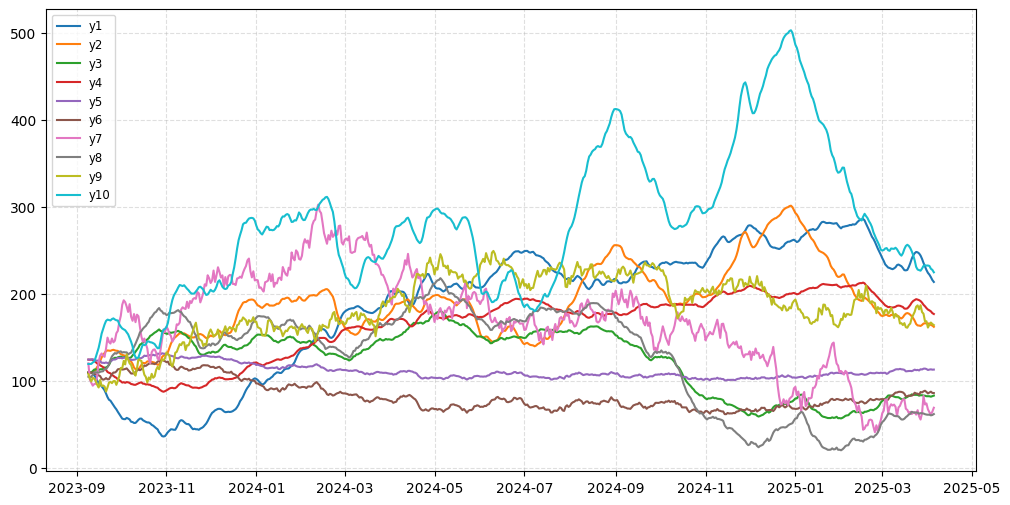

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(sample_df, label = sample_df.columns.values)
plt.grid(linestyle = '--', alpha = 0.4)
plt.legend(loc = 'upper left', fontsize = 'small')
plt.show()

On the chart above multiple potentially cointegrated pairs are visible. We choose y3 and y8.

In [11]:
coint_df = sample_df[['y3', 'y8']]
coint_test_df = test_df[['y3', 'y8']]
coint_df.head()

,y3,y8
date,,
2023-09-09,109.41,104.66
2023-09-10,109.41,104.34
2023-09-11,109.41,104.23
2023-09-12,111.12,107.23
2023-09-13,112.92,109.71


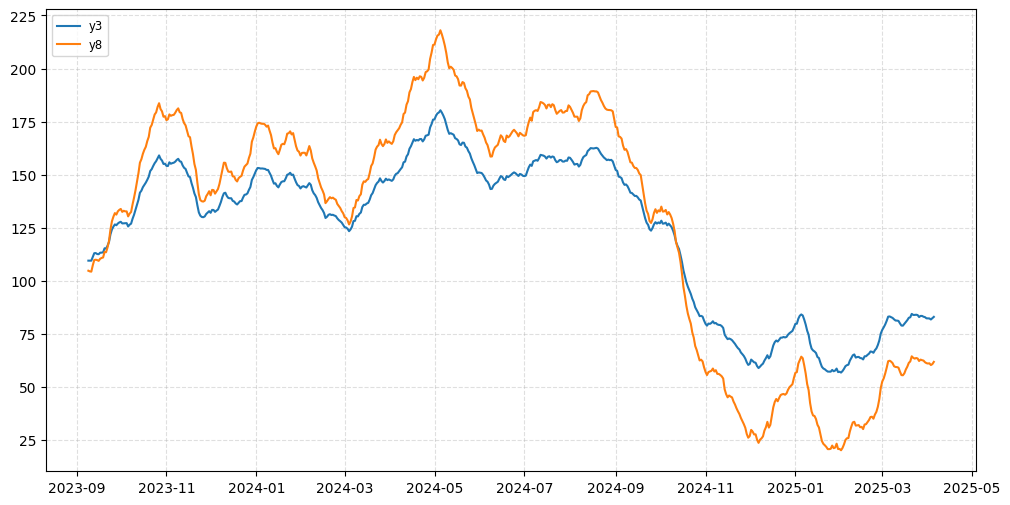

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(coint_df, label = coint_df.columns.values)
plt.grid(linestyle = '--', alpha = 0.4)
plt.legend(loc = 'upper left', fontsize = 'small')
plt.show()

Clearly we can observe long term relationship between those two time series, where for most of the time Y8 is above Y3, with that behaviour changing around 2024-10. In further steps we will examine this relationship more formally by running tests for cointegration.

### Engle-Granger Two-Step approach

As we already mentioned, series are cointegrated when both are $I(n)$, but their linear combination is $I(n-1)$. Most often we deal with series $I(1)$, therefore one way to check if series are corerlated is to test whether both series are $I(1)$ and if there is some linear combination of them which is $I(0)$.

This procedure consists of two steps as its name suggests:
1. Testing both series for stationarity. ADF test can be used.
2. Fitting linear regression model and testing stationarity of residuals.


#### Stationatity

Stationarity is an important concept in time series analysis. Weak stationarity assumes constant mean, variance and autocovariance over time. For our case stationarity needs to be assesed for cointegration testing (check whether both series are $I(1)$) and to determine integration order in ARIMA.

##### Testing for stationarity

Common way to check stationarity is visual analysis followed by statistical test like ADF test. We would expect stationary series to fluctuate over constant mean with irregular deviations of similar size. For both of our series we can clearly see some periods with upward trend and some with downward trend which implies no constant mean over time and non-stationarity of the series. 

We can investigate this further with Augmented Dickey-Fuller test for unit root. ADF test statistic is derived assuming unit root existance (there exists root of the characteristic equation equal 1) implying non-stationarity. Test statistic does not follow any standard probability distribution and critical values were explicitly derived by Dickey and Fuller what is known as Dickey-Fuller table. For the statistical inference to be meaningful we need to make sure that the error term of model constructed for the test does not exhibit autocorrelation. For this purpose we simultaneously perform Breush-Godfrey tests for autocorrelation for some predetermined numbers of augmentations.



In [13]:
adf_test(coint_df['y3'], max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-0.759993,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
1,1,-0.544253,-2.567,-1.941,-1.616,0.0000,0.0000,0.0002
2,2,-0.540168,-2.567,-1.941,-1.616,0.0088,0.0704,0.1501
3,3,-0.611177,-2.567,-1.941,-1.616,0.1565,0.2571,0.3630
4,4,-0.659028,-2.567,-1.941,-1.616,0.1663,0.3769,0.4610
5,5,-0.611546,-2.567,-1.941,-1.616,0.3329,0.6022,0.6546
6,6,-0.568708,-2.567,-1.941,-1.616,0.6304,0.9263,0.4356
7,7,-0.568161,-2.567,-1.941,-1.616,0.8439,0.9448,0.4933
8,8,-0.591811,-2.567,-1.941,-1.616,0.6727,0.2976,0.1553
9,9,-0.592219,-2.567,-1.941,-1.616,0.3339,0.1977,0.3719


In [14]:
adf_test(coint_df['y8'], max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-0.689938,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
1,1,-0.600750,-2.567,-1.941,-1.616,0.0000,0.0000,0.0001
2,2,-0.639475,-2.567,-1.941,-1.616,0.0055,0.0501,0.1663
3,3,-0.722358,-2.567,-1.941,-1.616,0.0995,0.1913,0.3980
4,4,-0.777581,-2.567,-1.941,-1.616,0.1420,0.4569,0.6562
5,5,-0.736609,-2.567,-1.941,-1.616,0.2696,0.6076,0.7813
6,6,-0.690157,-2.567,-1.941,-1.616,0.7372,0.9132,0.6784
7,7,-0.688413,-2.567,-1.941,-1.616,0.9215,0.9861,0.8648
8,8,-0.706560,-2.567,-1.941,-1.616,0.6864,0.6041,0.3621
9,9,-0.722980,-2.567,-1.941,-1.616,0.5234,0.5181,0.5370


Results of ADF testing procedure for both series are shown above. In both cases null hypothesis is strongly rejected, and 3 augmentations is enough to get rid of residuals autocorrelation. We therefore conclude that both series are non-stationary.

In [15]:
# Introduce first differences

coint_df['dy3'] = coint_df['y3'].diff()
coint_df['dy8'] = coint_df['y8'].diff()

In [16]:
coint_df.dropna(inplace = True)

In [17]:
adf_test(coint_df['dy3'], max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-11.281565,-2.567,-1.941,-1.616,0.0000,0.0001,0.0005
1,1,-8.315173,-2.567,-1.941,-1.616,0.0255,0.1312,0.2201
2,2,-7.194565,-2.567,-1.941,-1.616,0.1897,0.3081,0.4188
3,3,-6.387283,-2.567,-1.941,-1.616,0.2107,0.4619,0.5456
4,4,-6.349465,-2.567,-1.941,-1.616,0.4175,0.6993,0.7520
5,5,-6.576117,-2.567,-1.941,-1.616,0.7600,0.9623,0.5049
6,6,-6.031431,-2.567,-1.941,-1.616,0.9363,0.9745,0.5661
7,7,-5.867335,-2.567,-1.941,-1.616,0.7849,0.3759,0.1922
8,8,-5.472057,-2.567,-1.941,-1.616,0.4528,0.2428,0.4244
9,9,-5.396504,-2.567,-1.941,-1.616,0.4245,0.1323,0.2238


In [18]:
adf_test(coint_df['dy8'], max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-11.714393,-2.567,-1.941,-1.616,0.0000,0.0000,0.0001
1,1,-8.389563,-2.567,-1.941,-1.616,0.0064,0.0651,0.2042
2,2,-7.344828,-2.567,-1.941,-1.616,0.1132,0.2224,0.4451
3,3,-6.397908,-2.567,-1.941,-1.616,0.1673,0.5226,0.7226
4,4,-6.302370,-2.567,-1.941,-1.616,0.3149,0.6820,0.8457
5,5,-6.639264,-2.567,-1.941,-1.616,0.8449,0.9651,0.7266
6,6,-6.089706,-2.567,-1.941,-1.616,0.9718,0.9959,0.9061
7,7,-5.870891,-2.567,-1.941,-1.616,0.8149,0.6954,0.4120
8,8,-5.517372,-2.567,-1.941,-1.616,0.6721,0.5975,0.5909
9,9,-5.369267,-2.567,-1.941,-1.616,0.2701,0.5301,0.4562


Results above show that null hypothesis stating unit root existance is strongly rejected. Therefore we conclude that both series y3 and y8 are $I(1)$

However unit root tests have significant drawdown. Unit root specifically determines lack of mean reverting behavior of analyzed series. But constant mean is only 1 out of 3 conditions for weak stationarity. Financial time series often even after differencing exibits non-stationarity even if according to unit root test we would reject null hypothesis and assume stationarity. Take for example stock prices. Nominal changes in prices are proportional to the price, meaning that when stock price increases nominal changes increases as well implying non-constant variance. Therefore it may be better to first take logarithmic transformation of analyzed financial series. Then first differences of such series would be logarithmic returns, that usually can be treated approximately as percentage returns. 

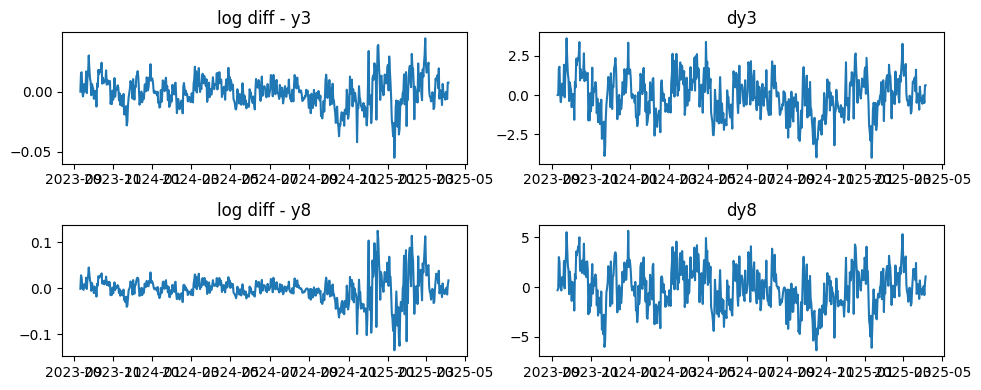

In [19]:
fig, axs = plt.subplots(2, 2, figsize = (10, 4))

axs[0, 0].plot(np.log(coint_df['y3']).diff().dropna())
axs[0, 0].set_title('log diff - y3')

axs[0, 1].plot(coint_df['dy3'])
axs[0, 1].set_title('dy3')

axs[1, 0].plot(np.log(coint_df['y8']).diff().dropna())
axs[1, 0].set_title('log diff - y8')

axs[1, 1].plot(coint_df['dy8'])
axs[1, 1].set_title('dy8')

plt.tight_layout()

Logarithm of differenced series looks less stationary, therefore we continue with simple differences.

#### Linear regression

In [20]:
# OLS estimation with constant, 
X = sm.add_constant(coint_df['y8'])
model_ols = OLS(coint_df['y3'], X).fit()

In [21]:
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y3   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.919e+07
Date:                Thu, 03 Jul 2025   Prob (F-statistic):               0.00
Time:                        21:49:13   Log-Likelihood:                 392.84
No. Observations:                 574   AIC:                            -781.7
Df Residuals:                     572   BIC:                            -773.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.1597      0.012   3544.805      0.000      44.135      44.184
y8             0.6249   8.91e-05   7013.864      0.000       0.625       0.625
==============================================================================
Omnibus:                        0.521   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.771   Jarque-Bera (JB):                0.623
Skew:                           0.015   Prob(JB):                        0.732
Kurtosis:                       2.841   Cond. No.                         341.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

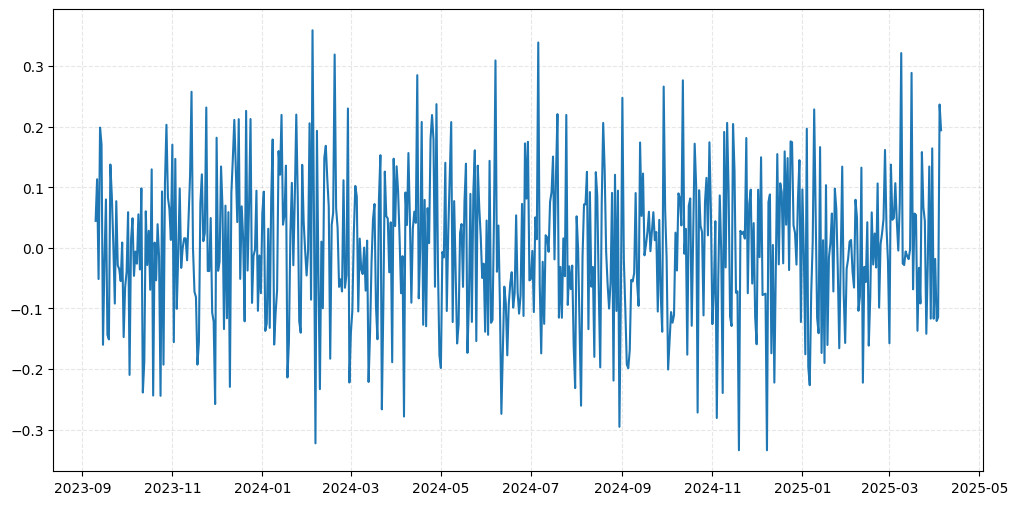

In [22]:
# Residuals plot
plt.figure(figsize = (12, 6))
plt.plot(model_ols.resid, label = 'Residuals')
plt.grid(linestyle = '--', alpha = 0.3)
plt.show()

In [23]:
# Residuals ADF test
adf_test(model_ols.resid, max_aug = 10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-24.195427,-2.567,-1.941,-1.616,0.7942,0.9046,0.7657
1,1,-17.359187,-2.567,-1.941,-1.616,0.5567,0.7678,0.6356
2,2,-14.055510,-2.567,-1.941,-1.616,0.1686,0.4545,0.3943
3,3,-12.511774,-2.567,-1.941,-1.616,0.5572,0.7314,0.6233
4,4,-11.487024,-2.567,-1.941,-1.616,0.3857,0.7239,0.6263
5,5,-10.541093,-2.567,-1.941,-1.616,0.2115,0.6694,0.6649
6,6,-9.095086,-2.567,-1.941,-1.616,0.4238,0.8007,0.3517
7,7,-8.589555,-2.567,-1.941,-1.616,0.3556,0.5419,0.6032
8,8,-7.933286,-2.567,-1.941,-1.616,0.5676,0.6388,0.7551
9,9,-7.329045,-2.567,-1.941,-1.616,0.6197,0.7375,0.6847


Null hypothesis of ADF test is strongly rejected, thus we conclude that series y3 and y8 are cointegrated. From OLS estimates we get normalized cointegration vector. It is $[1, -44.16, -0.625]$, where $1$ is y3 coefficient, $-44.16$ is constant and $-0.625$ is y8 coefficient:
$$
y_{3_t} - 44.16 - 0.625 y_{8_t} = \epsilon_t \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

## VECM Model ##

### Johansen test
Another way of testing for cointegration of two time series given both are I(1) is Johansen Test, it requires regular VAR to be respecified to VECM as shown below.

 $ΔYt = ΠYt−p + Γ1ΔYt−1 + Γ2ΔYt−2 + . . . + Γp−1ΔYt−(p−1) + εt$

where Π matrix can be interpreted as long-run coefficient matrix and Γ is coefficient matrix of lags of the dependent variable. At this point is worth nothing the similarity between this equation and ADF test for which we have first differenced term on left-hand side and lagged values and differences on the right side of the equation.

Because lag length can affect this Johansen test, we should first decide how many of them will be taken into consideration. Because we are dealing with financial asset prices first what comes to mind is 5 lags. But to make more informed decision we can employ information criteria.

In [24]:
model_var = VAR(coint_df[['y3', 'y8']], freq='D')
results = model_var.select_order(maxlags=10)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.910       3.926       49.91       3.916
1       -2.737      -2.691     0.06475      -2.719
2       -3.243      -3.166     0.03903      -3.213
3       -3.276     -3.168*     0.03780     -3.234*
4      -3.278*      -3.139    0.03771*      -3.224
5       -3.271      -3.102     0.03798      -3.205
6       -3.266      -3.066     0.03816      -3.188
7       -3.263      -3.032     0.03828      -3.173
8       -3.260      -2.998     0.03840      -3.158
9       -3.250      -2.958     0.03879      -3.136
10      -3.240      -2.917     0.03918      -3.114
--------------------------------------------------


We are looking at lowest values for each criteria. We can see that two of the information criteria are pointing to 3 lags and two to 4. Let's use method for picking up the most optimal number of lags.

In [25]:
selct_var_order(coint_df[['y3', 'y8']], max_lags=10)

,aic,bic,hqic,fpe
1,1,1,1,1
2,2,2,2,2
3,3,2,3,3
4,4,3,3,4
5,4,3,3,4
6,4,3,3,4
7,4,3,3,4
8,4,3,3,4
9,4,3,3,4
10,4,3,3,4


Given that the decision here will be somewhat arbitrary we are choosing 3 number of lags to simplify the model.


#### Performing Johansen test

Distribution for two tests which we are going to run is non-standard and cirtical values depend on  We are performing this test to verify if cointegrated vector exists for those two time series. Following variables needs to be specified:
* k_ar_diff - number of lagged differences. Because we operate on lagged differences this number is k-1 where k is the number of lags in original VAR model.
* det_order - here we are assuming that mean of our cointegration process is equal to 0 (has no additional constant term), is different than 0 but constant or is trending. We are chosing second option.

It also depends on number of variables and number of cointegrating vectors but first is indicated by the data and second is implied by tests.

In [26]:
# Perform Johansen test
# K=3 in levels VAR -> k_ar_diff = K-1 = 2 lags in VECM differences
# ecdet = "const" -> det_order = 0 (constant in CE)

johansen_result = coint_johansen(sample_df[['y3', 'y8']], det_order=0, k_ar_diff=2)

print("Johansen Test Results:")
print("Eigenvalues:")
print(johansen_result.eig)
print("\nTrace Statistic:")
print(johansen_result.lr1)
print("\nCritical Values (90%, 95%, 99%) for Trace Statistic:")
print(johansen_result.cvt)
print("\nMaximum Eigenvalue Statistic:")
print(johansen_result.lr2)
print("\nCritical Values (90%, 95%, 99%) for Max Eigenvalue Statistic:")
print(johansen_result.cvm)

Johansen Test Results:
Eigenvalues:
[0.2617199  0.00138514]

Trace Statistic:
[174.35594106   0.79284787]

Critical Values (90%, 95%, 99%) for Trace Statistic:
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Maximum Eigenvalue Statistic:
[173.56309318   0.79284787]

Critical Values (90%, 95%, 99%) for Max Eigenvalue Statistic:
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [27]:
print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvt[i, 2]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 2]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1']  # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvm[i, 2]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 2]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 174.356
  Critical Value (95%): 19.935
  Result: Reject H0 at 5% significance level.
H0: r <= 1
  Trace Statistic: 0.793
  Critical Value (95%): 6.635
  Result: Cannot reject H0 at 5% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 173.563
  Critical Value (95%): 18.520
  Result: Reject H0 at 5% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 0.793
  Critical Value (95%): 6.635
  Result: Cannot reject H0 at 5% significance level.


Trace Test - is a joint test which states that the number of cointegrating vectors is less than or equal r.
Max Eigenvalue Test - is based on testing each eigenvalue separately and null is that number of cointegrating vector is r.
In both cases for Trace and Max Eigenvalue tests we can see that H0 indicating that there is **no cointegrating vector can be rejected**. However, we **fail** to reject H0 that there is **one cointegrating vector** thus implying that we have exactly one cointegrating vector and series is cointegrated.

---

## VECM model

Following variables will be used in our VECM model:
* k_ar_diff as previously,
* cointegration as already establish is of rank one,
* freq =  d/daily,
* deterministic refers to constant term added to mean of our cointegration process.

In [28]:
# Estimate VECM
vecm_model = VECM(coint_df[['y3', 'y8']], k_ar_diff=2, coint_rank=1, deterministic='ci', freq='D')
vecm_results = vecm_model.fit()

Let's see the results:

In [29]:
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y3
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y3          0.2079      0.481      0.432      0.666      -0.735       1.151
L1.y8          0.1882      0.299      0.629      0.529      -0.398       0.775
L2.y3          0.0521      0.337      0.155      0.877      -0.608       0.712
L2.y8          0.0933      0.210      0.445      0.656      -0.317       0.504
Det. terms outside the coint. relation & lagged endog. parameters for equation y8
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y3          0.2731      0.778      0.351      0.725      -1.251       1.797
L1.y8          0.3392      0.484      0.701      0.483      -0.609       1.287
L2.y3          0.0812      0.544      0.149   

The VECM is given by:

$$\Delta\boldsymbol{y}_t = \Pi\boldsymbol{y}_{t-1} + \Gamma_1\Delta\boldsymbol{y}_{t-1} + ... + \Gamma_p\Delta\boldsymbol{y}_{t-p} + \boldsymbol{c}_d + \boldsymbol{\varepsilon}_t$$

where long run coefficient matrix is described as:
$$
\boldsymbol{\Pi}=\alpha\beta'=\left[
	\begin{array}{ccc}
	\alpha_{11} \\
	\alpha_{21} \\
	\end{array}
\right]
\left[
	\begin{array}{cccc}
\beta_{11} \quad \beta_{21} \\
 \end{array}
\right]
$$


let's see what values it takes in our case:

In [30]:
print("\nLong-run coefficient matrix:")
print(f"{vecm_results.alpha} {vecm_results.beta[:, 0] / vecm_results.beta[0, 0]}")


Long-run coefficient matrix:
[[0.43347322]
 [2.38384444]] [ 1.         -0.62496084]


**Interpretations:**

Alphas ( 'adjustment parameters' )
* $\alpha_{11}$ - we see it being positive, and in this case we would expect negative sign, but coefficient is not statistically significant.
* $\alpha_{12}$ - is positive 2.386 and statistically significant, meaning that correction mechanism works in expected direction. Variable should return to the long-term equilibrium - when it's above it should adjust downwards and below it adjust upwards.

 Betas ( coingegrating vectors )
* $\beta_{11}$ - normalization applied thanks to decomposition of Π not being unique.
* $\beta_{12}$ - negative sign tells us that y$_{1}$ it is positively related to y$_{2}$. In perfect equilibrium we would have y$_{1}$ = 0.625 * y$_{2}$.

Lag terms:
$$\Gamma_1\Delta\boldsymbol{y}_{t-1} + ... + \Gamma_p\Delta\boldsymbol{y}_{t-p} + \boldsymbol{c}_d + \boldsymbol{\varepsilon}_t$$

this represents short-run dynamics outside cointegration relation. None of the coefficients is statistically significant thus we are ommiting interpretation.

---

**We are reparametrizing VECM to VAR for further examination of the relations**

In [31]:
# Estimate VAR
var_model = VAR(coint_df[['y3', 'y8']], freq='D')
var_results = var_model.fit(4)

#### Impulse Response Functions
Let's examine what effect have shocks applied to variables. We are applying 160 periods as variable to illustrate correction mechanism more clearly.

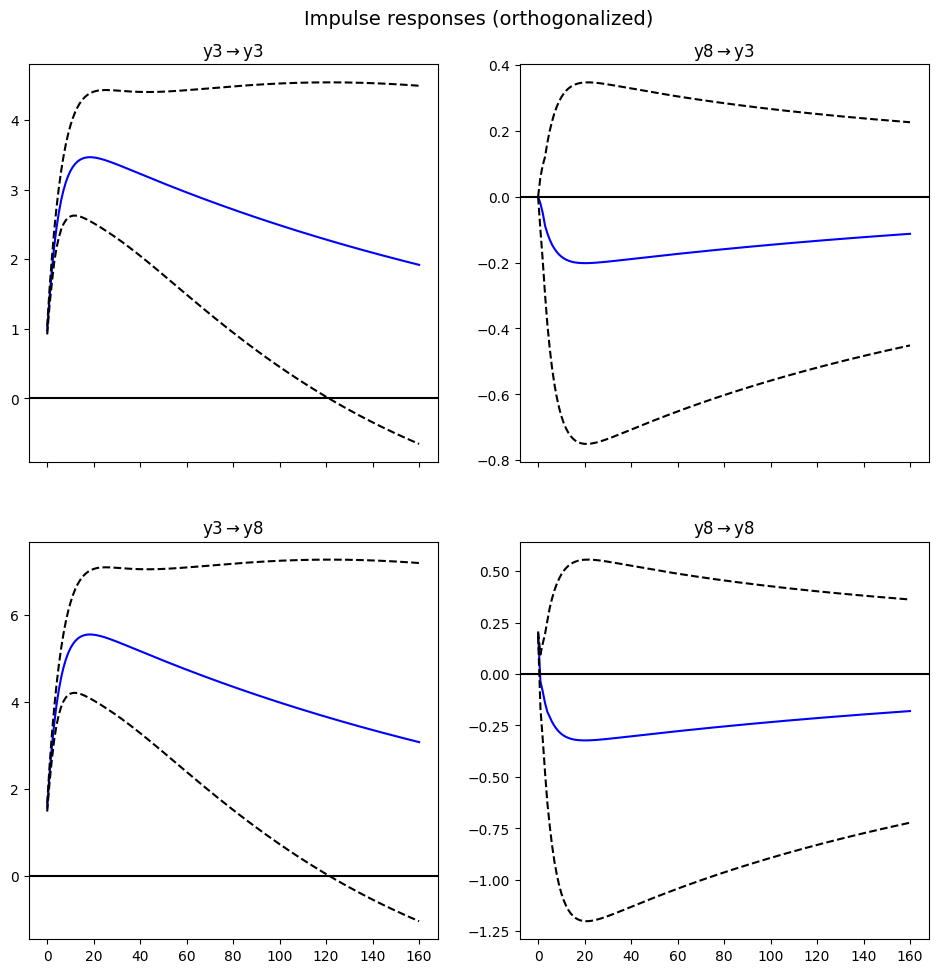

In [32]:
# Calculate and plot impulse response functions
irf = var_results.irf(160)  # 160 periods ahead
# and hence interpretations may change depending on variable ordering.
irf.plot(orth=True);

**Interpretation**

* y3->y3 : initial increase up to 25 days, and afterward slow decrease toward equilibrium
* y3->y8 : shock has bigger initial impact on y8, but as in previous case impacted variable is slowly converging toward 0
* y8->y3 : no first period impact of the y8 on y3. But we can observe negative impact on y3 and which converges back to 0
* y8->y8 : quick small jump at the beginning but as in previous case we are observing negative impact on first periods and convergence starting prior 25 period.

#### Forecast Error Variance Decomposition

FEVD can help us to see what is the proportion of variance in error terms between each variable due to their own shock or shocks of other variable.

FEVD for y3
            y3        y8
0     1.000000  0.000000
1     0.999862  0.000138
2     0.999556  0.000444
3     0.999047  0.000953
4     0.998656  0.001344
5     0.998354  0.001646
6     0.998112  0.001888
7     0.997921  0.002079
8     0.997766  0.002234
9     0.997637  0.002363
10    0.997529  0.002471
11    0.997438  0.002562
12    0.997361  0.002639
13    0.997295  0.002705
14    0.997237  0.002763
15    0.997188  0.002812
16    0.997144  0.002856
17    0.997105  0.002895
18    0.997072  0.002928
19    0.997041  0.002959
20    0.997014  0.002986
21    0.996990  0.003010
22    0.996968  0.003032
23    0.996949  0.003051
24    0.996931  0.003069

FEVD for y8
            y3        y8
0     0.984694  0.015306
1     0.995007  0.004993
2     0.997190  0.002810
3     0.997669  0.002331
4     0.997713  0.002287
5     0.997687  0.002313
6     0.997615  0.002385
7     0.997532  0.002468
8     0.997450  0.002550
9     0.997374  0.002626
10    0.997306  0.002694
11    0.997245  0.002755


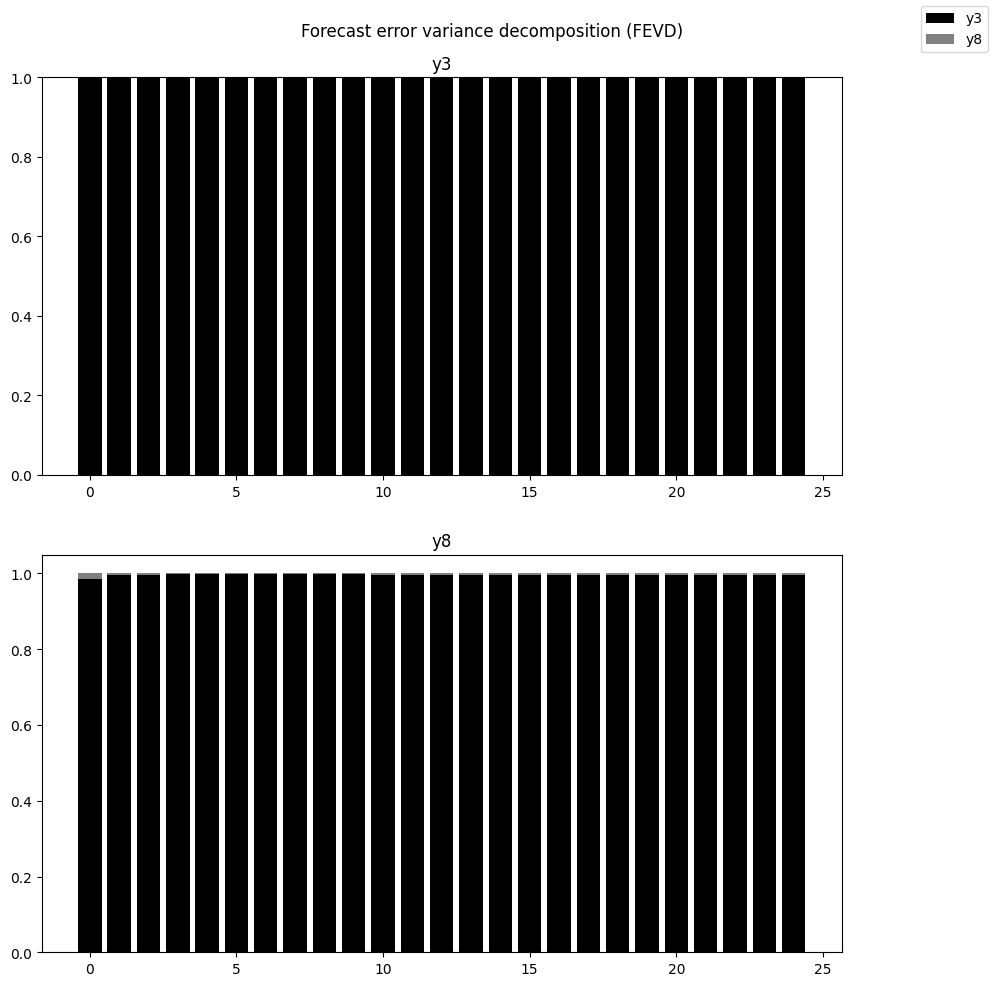

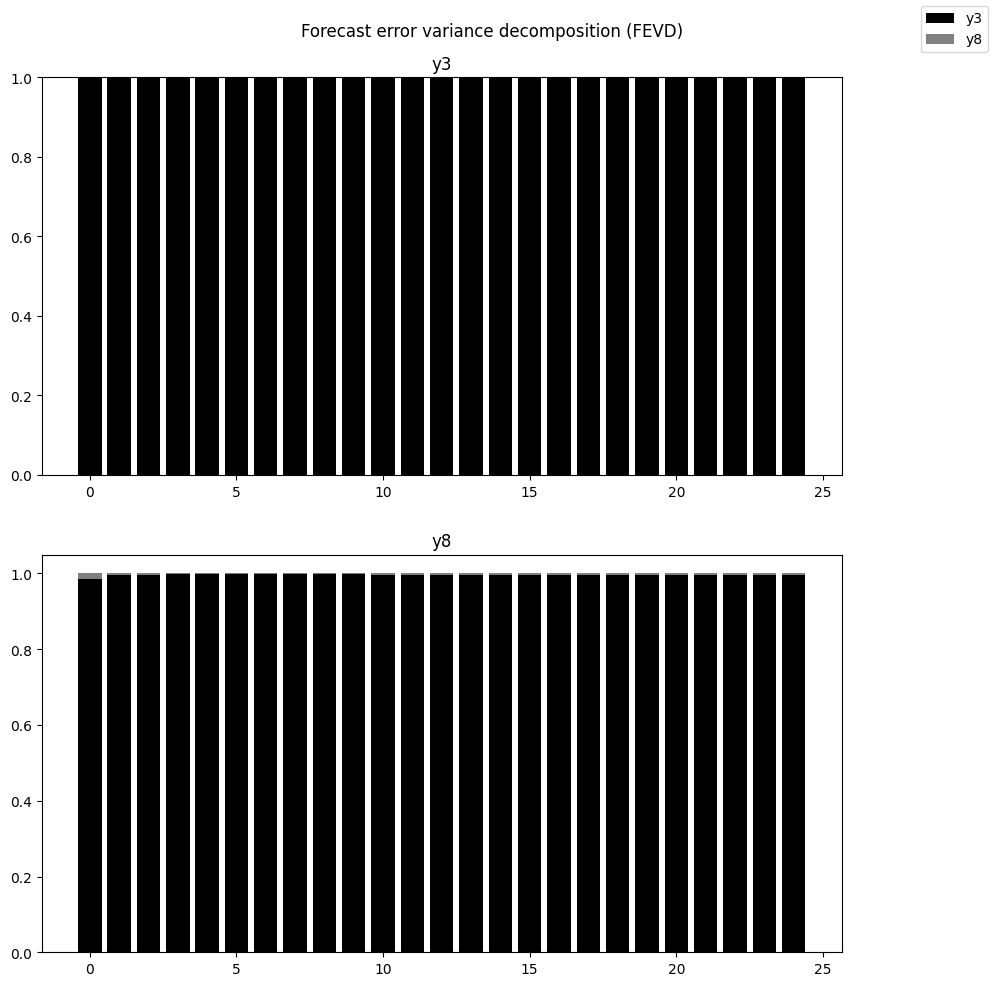

In [33]:
# Calculate and plot forecast error variance decomposition
fevd = var_results.fevd(25)  # 36 periods ahead
fevd.summary()

# Plot FEVD
var_results.fevd(25).plot()

We can see that variance of forecast error terms are explained mainly by changes in y3 for both variables. That confirms our main previous observations that shocks in y3 have impact on y8 but not other way around.

#### Autocorrelation in residuals

In [34]:
residuals = var_results.resid

residuals = pd.DataFrame(residuals, columns=['y3', 'y8'])

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_y3 = acorr_ljungbox(residuals['y3'], lags=[10], return_df=True)
ljung_box_y8 = acorr_ljungbox(residuals['y8'], lags=[10], return_df=True)
print("y3 Residuals:\n", ljung_box_y3)
print("\ny8 Residuals:\n", ljung_box_y8)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_y3['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y3 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y3 residuals.")
if ljung_box_y8['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y8 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y8 residuals.")


Ljung-Box Test for Serial Correlation in Residuals (lag=10):
y3 Residuals:
       lb_stat  lb_pvalue
10  10.051413   0.435994

y8 Residuals:
       lb_stat  lb_pvalue
10  10.501792   0.397625

Conclusion at alpha=0.05:
 - Cannot reject H0 (no serial correlation) for y3 residuals.
 - Cannot reject H0 (no serial correlation) for y8 residuals.


Test indicate that there is no significant autocorrelation in residuals of chosen VAR model with 10 lags.
Let's examine how relation between residuals looks on diagram:

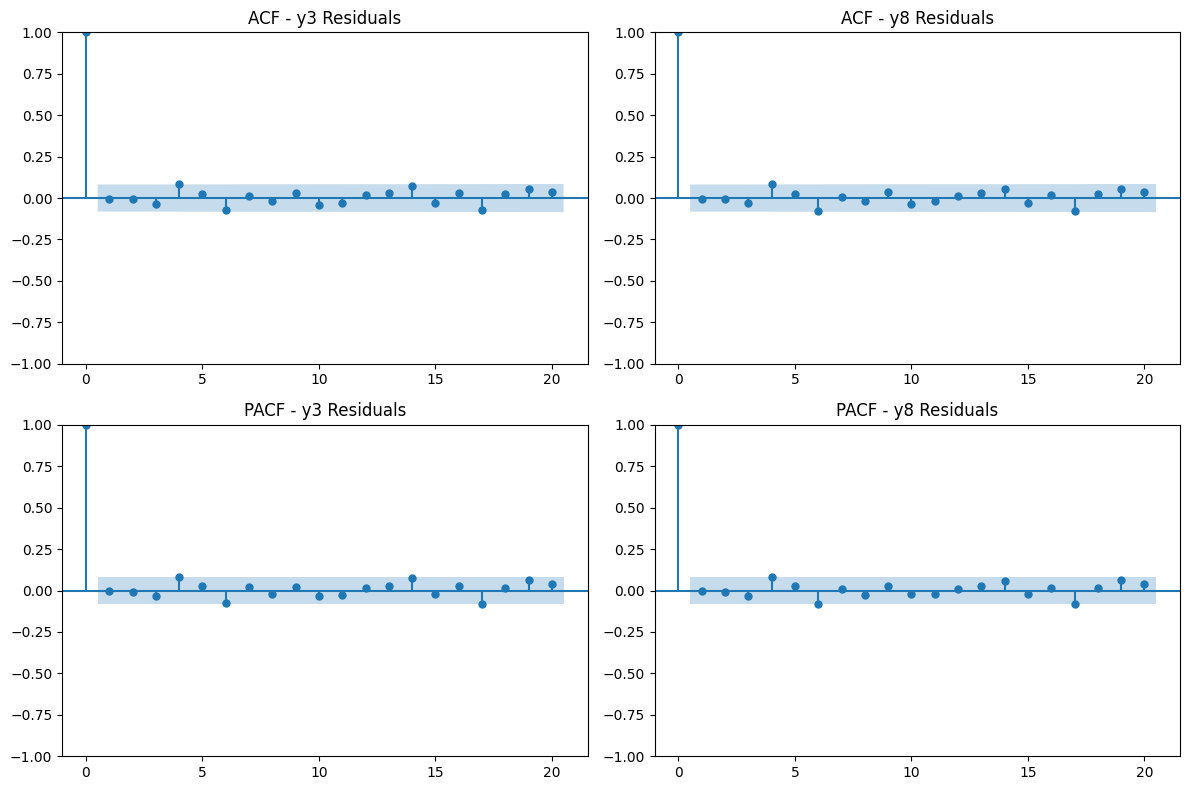

In [35]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals['y3'], ax=axes[0, 0], title='ACF - y3 Residuals', lags=20)
plot_pacf(residuals['y3'], ax=axes[1, 0], title='PACF - y3 Residuals', lags=20,
          method='ywm')  # 'ols' method might fail if near non-stationarity
plot_acf(residuals['y8'], ax=axes[0, 1], title='ACF - y8 Residuals', lags=20)
plot_pacf(residuals['y8'], ax=axes[1, 1], title='PACF - y8 Residuals', lags=20, method='ywm')
plt.tight_layout()
plt.show()

ACF and PACF for both variables shows that there might be some autocorrelation in 4th 6th and 17th lags.

Let's see how those would look like if we would add upt to 6th lag to our model.

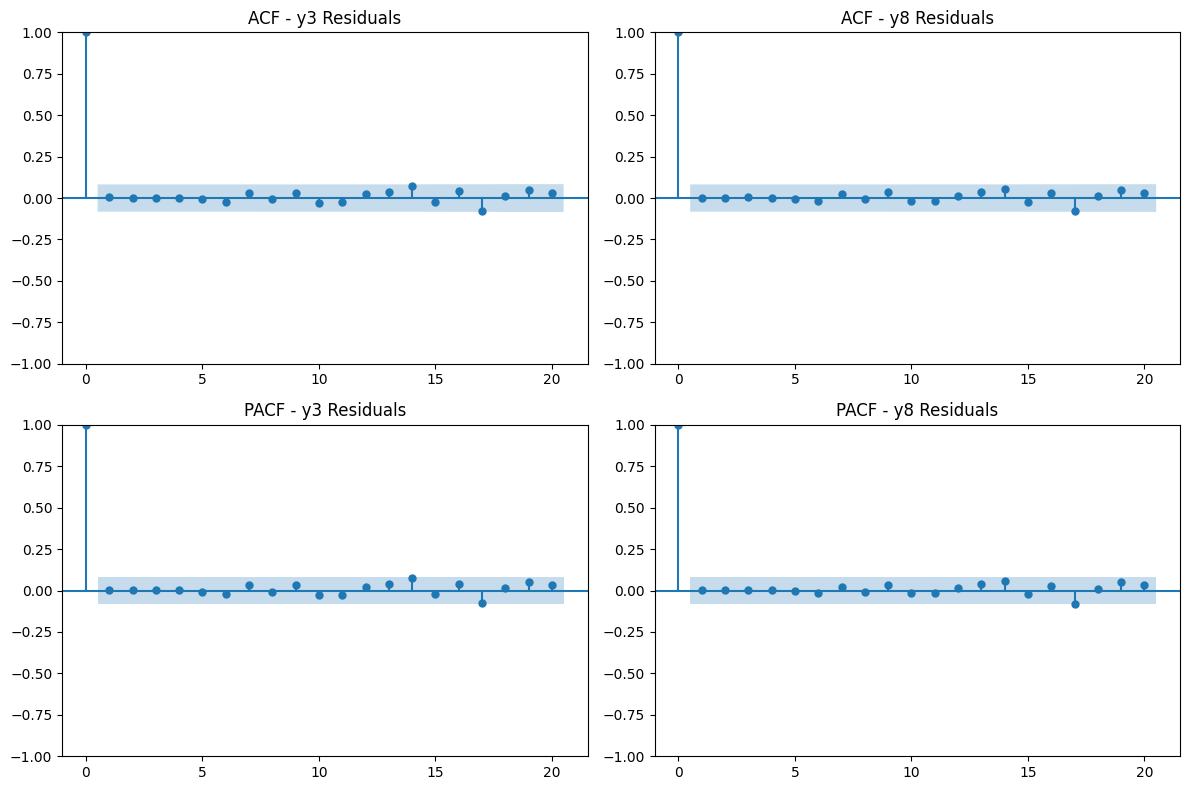

In [36]:
var_model_6 = VAR(coint_df[['y3', 'y8']], freq='D')
var_results_6 = var_model_6.fit(7)
resid_6 = var_results_6.resid

resid_6 = pd.DataFrame(resid_6, columns=['y3', 'y8'])

# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(resid_6['y3'], ax=axes[0, 0], title='ACF - y3 Residuals', lags=20)
plot_pacf(resid_6['y3'], ax=axes[1, 0], title='PACF - y3 Residuals', lags=20,
          method='ywm')  # 'ols' method might fail if near non-stationarity
plot_acf(resid_6['y8'], ax=axes[0, 1], title='ACF - y8 Residuals', lags=20)
plot_pacf(resid_6['y8'], ax=axes[1, 1], title='PACF - y8 Residuals', lags=20, method='ywm')
plt.tight_layout()
plt.show()

Incorporating more lags we removed autocorrelation between residuals. But given that the difference doesn't look that significant we won't respecify our previous model.

**Proceeding to checking normality of residuals:**

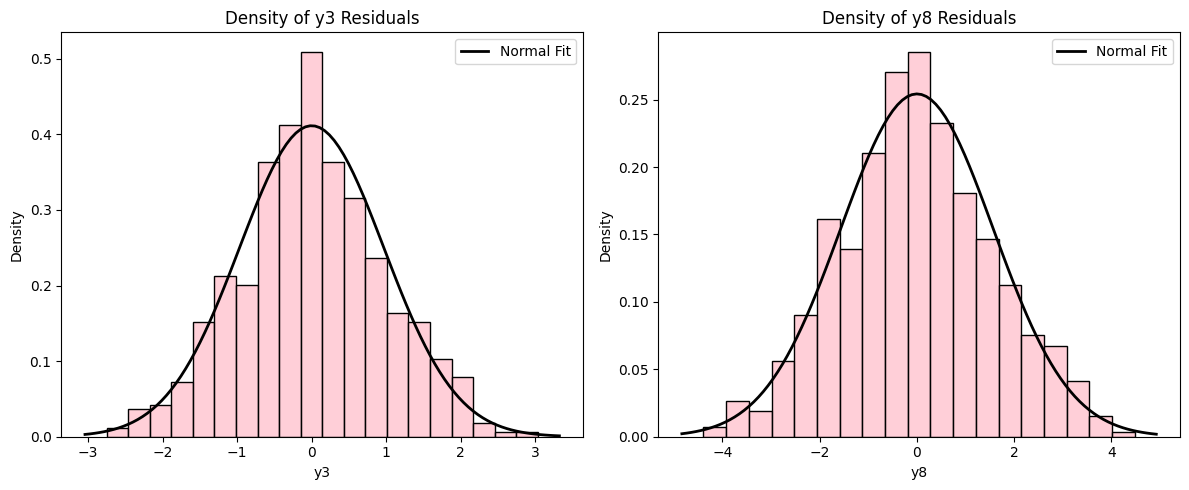

In [37]:
# Plot histograms of residuals with normal density overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals['y3'], kde=False, stat='density', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Density of y3 Residuals')
# Overlay normal distribution
mu_y3, std_y3 = residuals['y3'].mean(), residuals['y3'].std()
xmin_y3, xmax_y3 = axes[0].get_xlim()
x_y3 = np.linspace(xmin_y3, xmax_y3, 100)
p_y3 = norm.pdf(x_y3, mu_y3, std_y3)
axes[0].plot(x_y3, p_y3, 'k', linewidth=2, label='Normal Fit')
axes[0].legend()

sns.histplot(residuals['y8'], kde=False, stat='density', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Density of y8 Residuals')
# Overlay normal distribution
mu_y8, std_y8 = residuals['y8'].mean(), residuals['y8'].std()
xmin_y8, xmax_y8 = axes[1].get_xlim()
x_y8 = np.linspace(xmin_y8, xmax_y8, 100)
p_y8 = norm.pdf(x_y8, mu_y8, std_y8)
axes[1].plot(x_y8, p_y8, 'k', linewidth=2, label='Normal Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

Distribution is only a little bit denser in the middle, but we don't see huge tails or other characteristics of non-normal distribution. We will examine normality of distributions by running Jarque-Bera tests.

In [38]:
# Test for normality (Jarque-Bera test)
jb_y3_stat, jb_y3_pval, _, _ = jarque_bera(residuals['y3'])
jb_y8_stat, jb_y8_pval, _, _ = jarque_bera(residuals['y8'])

print("\nJarque-Bera Normality Test for Residuals:")
print(f"y3 Residuals: Statistic={jb_y3_stat:.3f}, p-value={jb_y3_pval:.3f}")
print(f"y8 Residuals: Statistic={jb_y8_stat:.3f}, p-value={jb_y8_pval:.3f}")

alpha_norm = 0.05
print(f"\nConclusion at alpha={alpha_norm}:")
if jb_y3_pval < alpha_norm:
    print(" - Reject normality for y3 residuals.")
else:
    print(" - Cannot reject normality for y3 residuals.")
if jb_y8_pval < alpha_norm:
    print(" - Reject normality for y8 residuals.")
else:
    print(" - Cannot reject normality for y8 residuals.")

# Multivariate Normality Test (using VECMResults method)
try:
    normality_test_results = vecm_results.test_normality()
    print("\nMultivariate Normality Test Results (using VECMResults method):")
    print(normality_test_results)
except Exception as e:
    print(f"\nCould not run multivariate normality test directly: {e}")


Jarque-Bera Normality Test for Residuals:
y3 Residuals: Statistic=0.423, p-value=0.809
y8 Residuals: Statistic=0.892, p-value=0.640

Conclusion at alpha=0.05:
 - Cannot reject normality for y3 residuals.
 - Cannot reject normality for y8 residuals.

Multivariate Normality Test Results (using VECMResults method):
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 1.230, critical value: 9.488>, p-value: 0.873>


There is not enough evidence to reject the H0 saying that distributions are normal.

---

## Forecasting using VECM

We are going to calculate forecast for the next 25 periods using VECM model. We alraedy have data divided into sample (575 observations) and test (25 observations) sets. Because we conducted all of previous operations on in sample data already, we can proceed directly to forecasting.

In [39]:
forecast_periods = 25
# We want both point forecast and most probable range (within 95 % confidence interval)
forecast_values = vecm_results.predict(steps=forecast_periods, alpha=0.05)
# Creating dataframe with all data for further research
forecast_df = pd.DataFrame(forecast_values[0], index=coint_test_df.index,
                           columns=['y3_fore', 'y8_fore'])
lower_df = pd.DataFrame(forecast_values[1], index=coint_test_df.index,
                           columns=['y3_lower', 'y8_lower'])
upper_df = pd.DataFrame(forecast_values[2], index=coint_test_df.index,
                           columns=['y3_upper', 'y8_upper'])

# Combine forecasts and intervals
forecast_merged= pd.concat([forecast_df, lower_df, upper_df], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_merged)


Forecasts and Confidence Intervals:
              y3_fore    y8_fore   y3_lower   y8_lower    y3_upper    y8_upper
date                                                                          
2025-04-06  83.386015  62.795176  81.477956  59.710947   85.294074   65.879405
2025-04-07  83.821903  63.488540  80.368097  57.942738   87.275709   69.034341
2025-04-08  84.167248  64.029018  79.063821  55.834813   89.270676   72.223223
2025-04-09  84.426314  64.440675  77.689055  53.632124   91.163573   75.249227
2025-04-10  84.624994  64.758007  76.294945  51.401013   92.955044   78.115002
2025-04-11  84.777009  65.000487  74.914922  49.192960   94.639097   80.808014
2025-04-12  84.893494  65.186256  73.566455  47.035674   96.220532   83.336838
2025-04-13  84.982670  65.328467  72.259338  44.944786   97.706002   85.712149
2025-04-14  85.050958  65.437374  70.998264  42.927691   99.103652   87.947058
2025-04-15  85.103246  65.520764  69.784807  40.986835  100.421686   90.054692
2025-04-16  85.

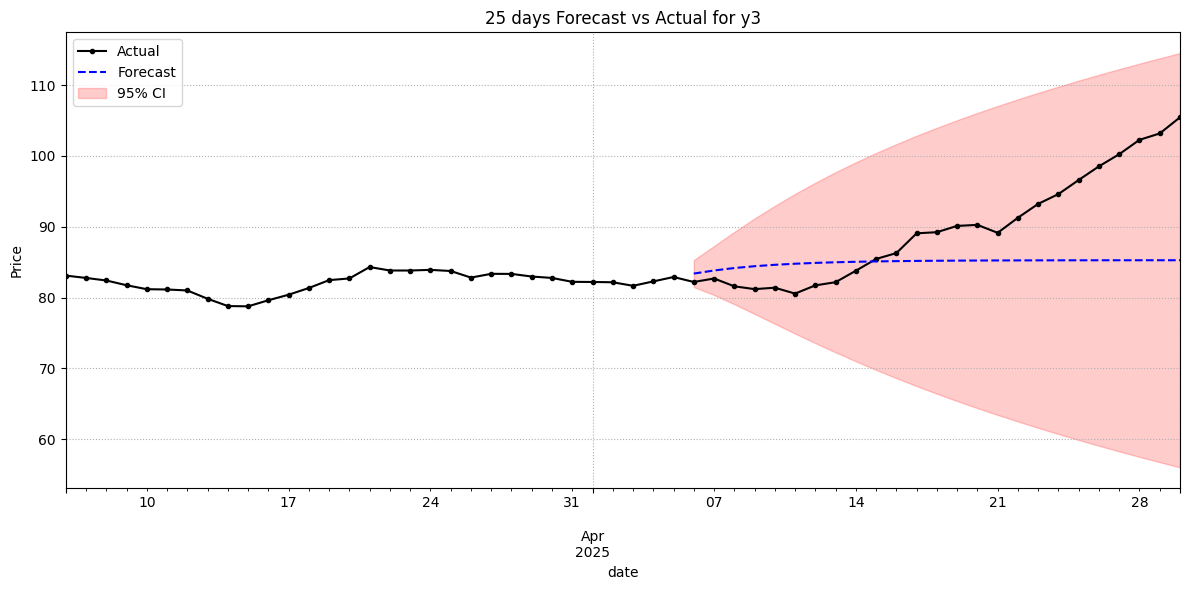

In [40]:
# Merge forecasts with the original data for plotting
df_merged = df[['y3', 'y8']].merge(forecast_merged, left_index=True, right_index=True, how='left')
plot_forecast_with_ci('2025-03-06',df_merged,'y3','y3_fore','y3_lower','y3_upper','25 days Forecast vs Actual for y3','Price')

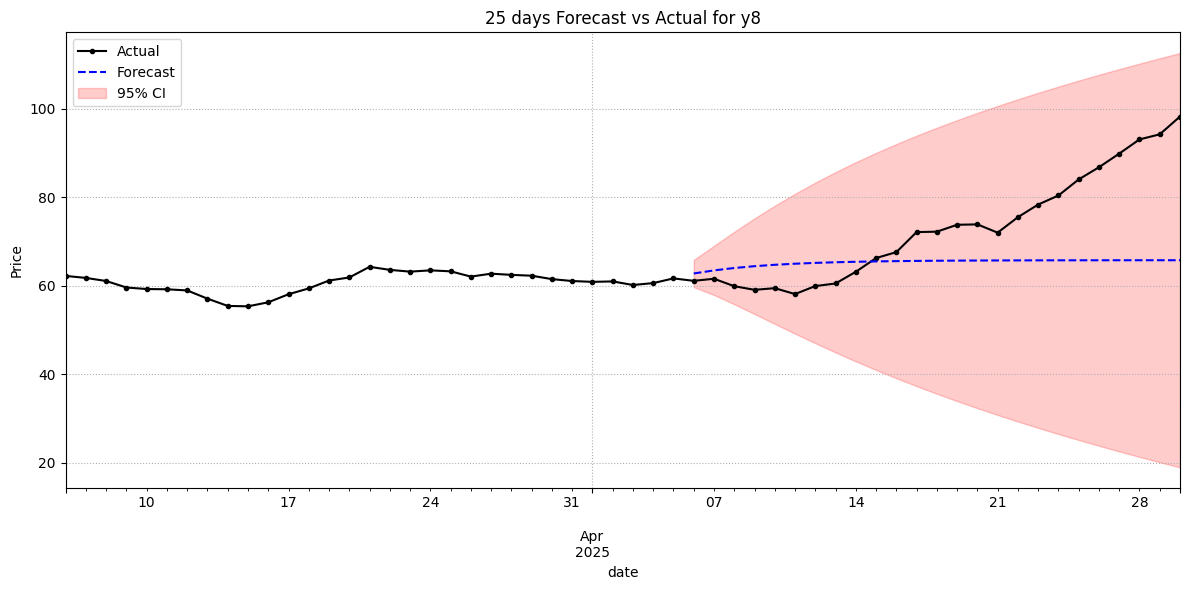

In [41]:
# Merge forecasts with the original data for plotting
# df_merged = df_original.merge(forecast_df, left_index=True, right_index=True, how='left')
plot_forecast_with_ci('2025-03-06',df_merged,'y8','y8_fore','y8_lower','y8_upper','25 days Forecast vs Actual for y8','Price')

Forecast is not close to the real prices of assets in neither of those cases. Actual values are within our 95% confidence interval though.
In following section we will examine metrics for our out-of-sample period forecast errors.

In [42]:
print_accuracy_measures(df_merged.dropna(),3,'y3','y8')

Forecast Accuracy Metrics for 3 lags:
                  y3          y8
MAE         6.563340   10.581120
MSE        75.908374  195.186893
RMSE        8.712541   13.970930
MAPE (%)    6.890769   13.129224
AMAPE (%)   7.264021   14.383043


---

## ARIMA
We will apply Box-Jenkins procedure to find p,d,q values for ARIMA(p, d, q). This procedure utilizes ACF and PACF to determine correspondingly right MA order and right AR model. We already have order of integration as we have shown that series are both non-stationary but their differences are stationary implying integration of order 1 - $I(1)$

Let's start with procedure for y2 series. We shown that it is $I(1)$ so we plot ACF and PACF for differenced series.

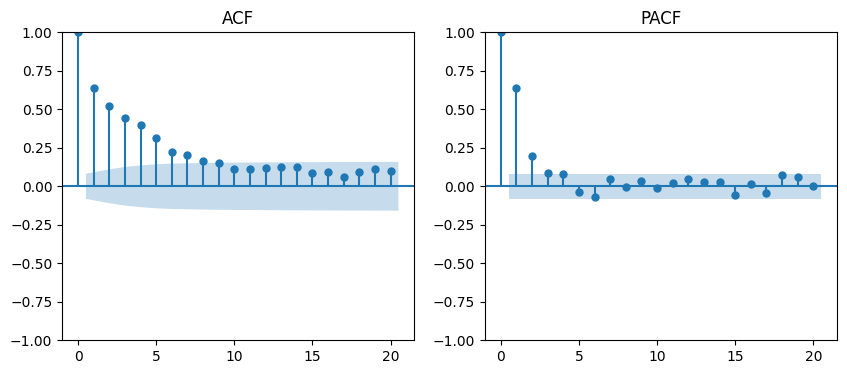

In [43]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(coint_df['dy3'], lags=20, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(coint_df['dy3'], lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

We observe quite interesting behavior - ACF is decaying exponentially, which would be expected for pure AR models. PACF shows significant spikes at lag 1 and 2. Lags 3, 4 and maybe 6 are just out of confidence interval. Most likely we should choose AR(2) model, however we are going to check also 1, 3 and 4 orders. We will compare models using information criteria.

Let's start with ARIMA(1, 1, 0) 

In [44]:
model = ARIMA(coint_df['y3'].values, order = (1,1,0))
arima_110 = model.fit()
print(arima_110.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -810.387
Date:                Thu, 03 Jul 2025   AIC                           1624.773
Time:                        21:49:18   BIC                           1633.475
Sample:                             0   HQIC                          1628.167
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6347      0.033     19.114      0.000       0.570       0.700
sigma2         0.9898      0.060     16.611      0.000       0.873       1.107
Ljung-Box (L1) (Q):                   9.12   Jarque-

In [45]:
ljung_test = acorr_ljungbox(arima_110.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   0.277430   0.998046
10  0.499419   0.999993
15  1.126439   0.999999
20  1.241286   1.000000
25  1.277208   1.000000


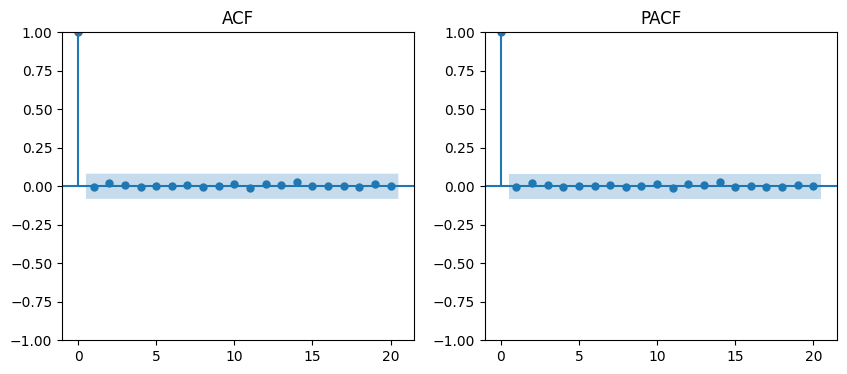

In [46]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_110.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_110.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

Model specification is correct. There is no autocorrelations in model residuals, and as usually we prefer simple models we could just take this one and move forward with the analysis as this model is basically the simplest one we can get. However, we can't really say that this model is certainly the best one without some comparison. It is therefore useful to study also different model specifications and compare them on information criteria basis (lower is better).

So let's now check ARIMA(2, 1, 0) and other specifications

In [47]:
model = ARIMA(coint_df['y3'].values, order = (2,1,0))
arima_210 = model.fit()
print(arima_210.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -798.720
Date:                Thu, 03 Jul 2025   AIC                           1603.439
Time:                        21:49:18   BIC                           1616.492
Sample:                             0   HQIC                          1608.531
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5074      0.043     11.883      0.000       0.424       0.591
ar.L2          0.2000      0.040      5.003      0.000       0.122       0.278
sigma2         0.9502      0.058     16.391      0.0

In [48]:
ljung_test = acorr_ljungbox(arima_210.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   0.168777   0.999414
10  0.356160   0.999999
15  0.908326   1.000000
20  1.031246   1.000000
25  1.067907   1.000000


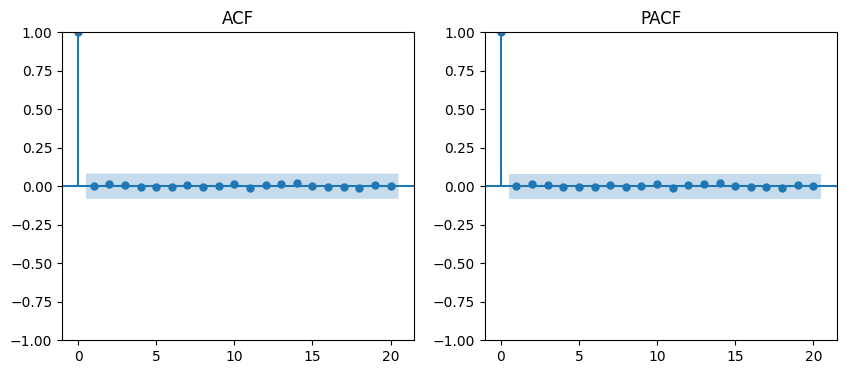

In [49]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_210.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_210.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

In [50]:
model = ARIMA(coint_df['y3'].values, order = (3,1,0))
arima_310 = model.fit()
print(arima_310.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -796.449
Date:                Thu, 03 Jul 2025   AIC                           1600.897
Time:                        21:49:19   BIC                           1618.301
Sample:                             0   HQIC                          1607.686
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4894      0.043     11.422      0.000       0.405       0.573
ar.L2          0.1548      0.046      3.333      0.001       0.064       0.246
ar.L3          0.0890      0.043      2.072      0.0

In [51]:
ljung_test = acorr_ljungbox(arima_310.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   0.195124   0.999165
10  0.364811   0.999999
15  0.932906   1.000000
20  1.065330   1.000000
25  1.102621   1.000000


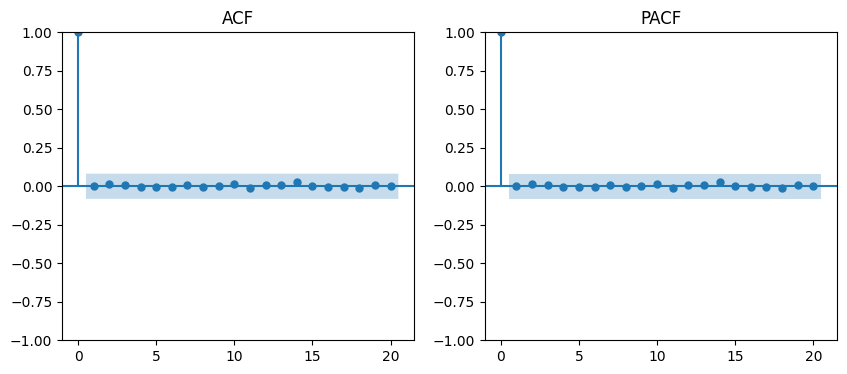

In [52]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_310.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_310.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

In [53]:
model = ARIMA(coint_df['y3'].values, order = (4,1,0))
arima_410 = model.fit()
print(arima_410.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -794.736
Date:                Thu, 03 Jul 2025   AIC                           1599.472
Time:                        21:49:19   BIC                           1621.227
Sample:                             0   HQIC                          1607.958
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4827      0.043     11.122      0.000       0.398       0.568
ar.L2          0.1425      0.047      3.016      0.003       0.050       0.235
ar.L3          0.0510      0.047      1.086      0.2

In [54]:
ljung_test = acorr_ljungbox(arima_410.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   0.246123   0.998535
10  0.411030   0.999997
15  0.949546   1.000000
20  1.092444   1.000000
25  1.122127   1.000000


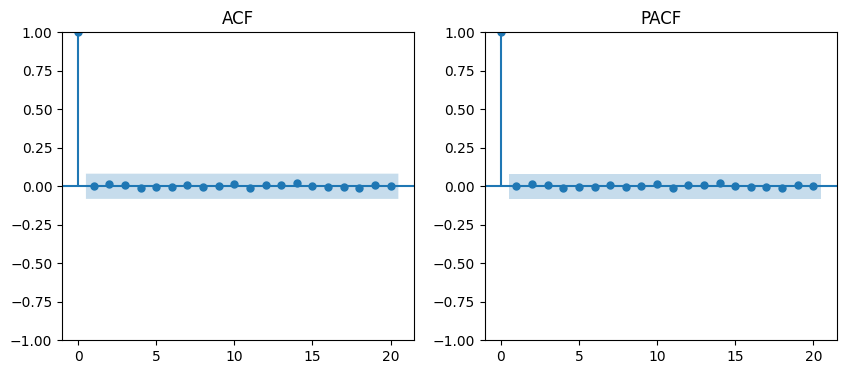

In [55]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_410.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_410.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

We can see that all specifications are technically correct. So let's see which one is the baset by information criteria

In [56]:
models = [arima_110, arima_210, arima_310, arima_410]
model_names = ["arima_110", "arima_210", "arima_310", "arima_410"]

aic = []
bic = []

for model in models:
    aic.append(model.aic)
    bic.append(model.bic)

In [57]:
y3_arima_res = pd.DataFrame({
    "AIC": aic,
    "BIC": bic
}, index=model_names)

In [58]:
y3_arima_res

,AIC,BIC
arima_110,1624.773123,1633.474894
arima_210,1603.439408,1616.492065
arima_310,1600.897447,1618.300990
arima_410,1599.472338,1621.226767


Results are ambiguous. BIC suggests that the best model is ARIMA(2, 1, 0) and AIC suggests model ARIMA(4, 1, 0). We will choose simpler model, in this case ARIMA(2, 1, 0) for further anaylysis.

---

Let's continue wuth analysis. We've already chosen model for y3 series. Now we have to do the same for y8 series

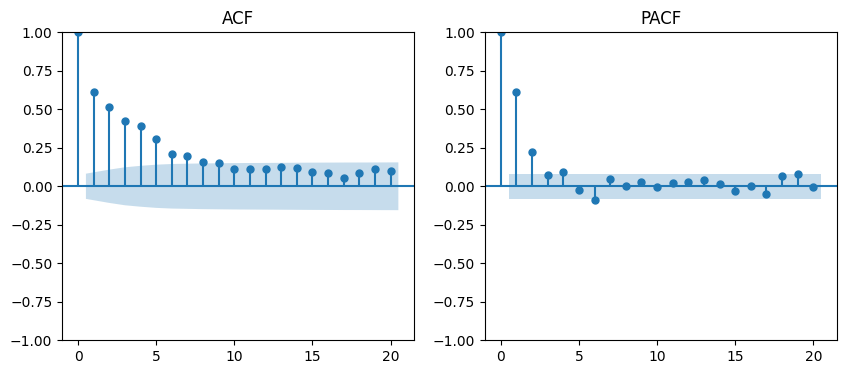

In [59]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(coint_df['dy8'], lags=20, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(coint_df['dy8'], lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

ACF and PACF look quite similar to those obtained for y3 series. But here we will check orders 1, 2, 4 and 6

In [60]:
model = ARIMA(coint_df['y8'].values, order = (1,1,0))
arima_110_2 = model.fit()
print(arima_110_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1099.933
Date:                Thu, 03 Jul 2025   AIC                           2203.866
Time:                        21:49:19   BIC                           2212.568
Sample:                             0   HQIC                          2207.260
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6118      0.034     17.917      0.000       0.545       0.679
sigma2         2.7197      0.167     16.284      0.000       2.392       3.047
Ljung-Box (L1) (Q):                  10.42   Jarque-

In [61]:
ljung_test = acorr_ljungbox(arima_110_2.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   1.265025   0.938489
10  1.789035   0.997716
15  3.227327   0.999369
20  3.684085   0.999976
25  3.837553   1.000000


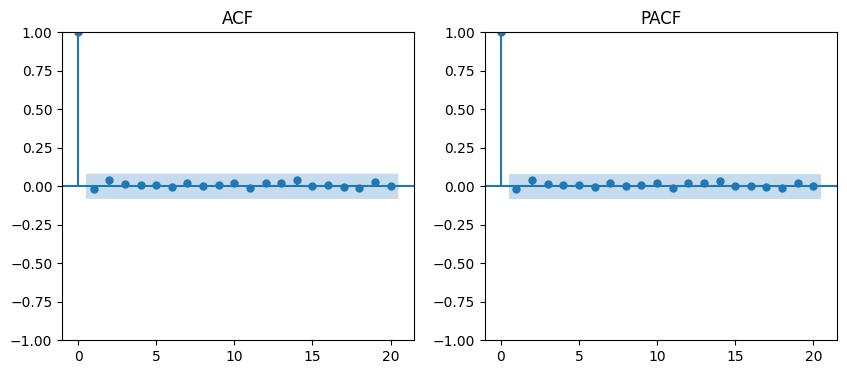

In [62]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_110_2.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_110_2.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

In [63]:
model = ARIMA(coint_df['y8'].values, order = (2,1,0))
arima_210_2 = model.fit()
print(arima_210_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1085.543
Date:                Thu, 03 Jul 2025   AIC                           2177.087
Time:                        21:49:20   BIC                           2190.140
Sample:                             0   HQIC                          2182.178
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4757      0.042     11.331      0.000       0.393       0.558
ar.L2          0.2217      0.039      5.694      0.000       0.145       0.298
sigma2         2.5860      0.161     16.071      0.0

In [64]:
ljung_test = acorr_ljungbox(arima_210_2.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   0.257446   0.998368
10  0.631328   0.999980
15  1.944073   0.999975
20  2.433232   0.999999
25  2.566793   1.000000


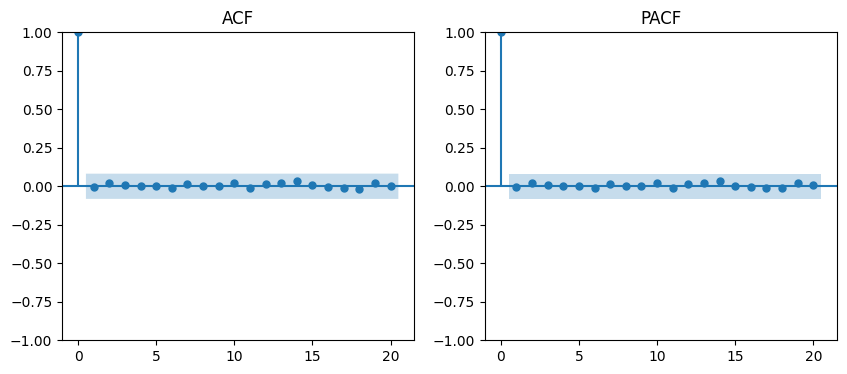

In [65]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_210_2.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_210_2.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

In [66]:
model = ARIMA(coint_df['y8'].values, order = (4,1,0))
arima_410_2 = model.fit()
print(arima_410_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1081.435
Date:                Thu, 03 Jul 2025   AIC                           2172.869
Time:                        21:49:20   BIC                           2194.624
Sample:                             0   HQIC                          2181.355
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4519      0.043     10.619      0.000       0.369       0.535
ar.L2          0.1679      0.046      3.647      0.000       0.078       0.258
ar.L3          0.0333      0.046      0.726      0.4

In [67]:
ljung_test = acorr_ljungbox(arima_410_2.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   0.552565   0.990072
10  0.929957   0.999877
15  2.188793   0.999946
20  2.708590   0.999998
25  2.816734   1.000000


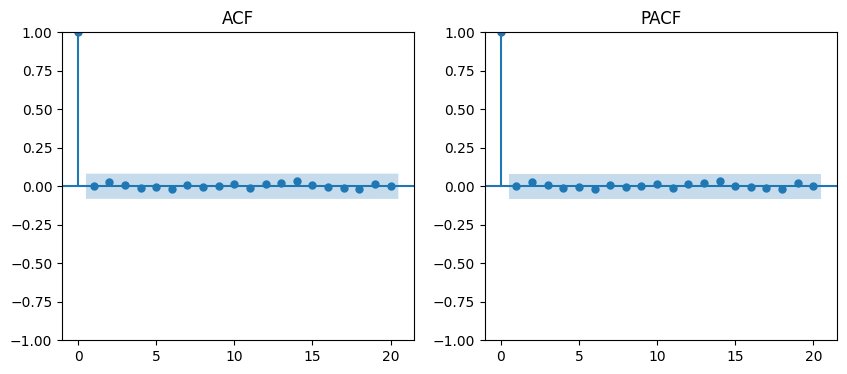

In [68]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_410_2.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_410_2.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

In [69]:
model = ARIMA(coint_df['y8'].values, order = (6,1,0))
arima_610_2 = model.fit()
print(arima_610_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  574
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -1078.966
Date:                Thu, 03 Jul 2025   AIC                           2171.931
Time:                        21:49:20   BIC                           2202.388
Sample:                             0   HQIC                          2183.812
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4519      0.043     10.531      0.000       0.368       0.536
ar.L2          0.1781      0.046      3.880      0.000       0.088       0.268
ar.L3          0.0410      0.046      0.892      0.3

In [70]:
ljung_test = acorr_ljungbox(arima_610_2.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
5   0.586120   0.988630
10  0.926386   0.999879
15  2.253465   0.999935
20  2.858631   0.999997
25  2.958960   1.000000


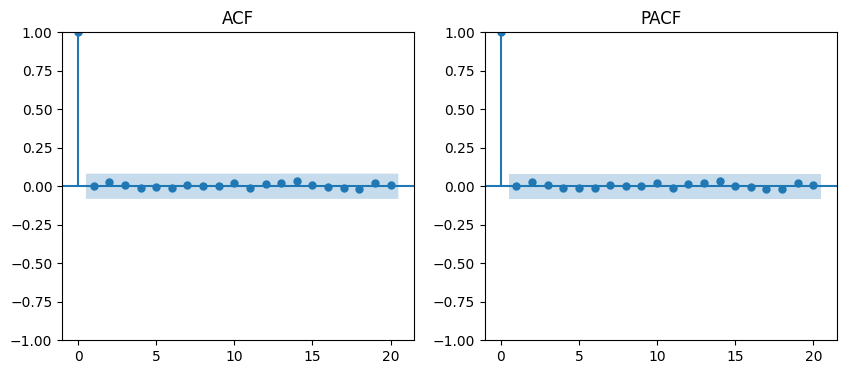

In [71]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_610_2.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_610_2.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

Again all studied specifications are technically correct

In [72]:
models = [arima_110_2, arima_210_2, arima_410_2, arima_610_2]
model_names = ["arima_110", "arima_210", "arima_410", "arima_610"]

aic = []
bic = []

for model in models:
    aic.append(model.aic)
    bic.append(model.bic)

In [73]:
y8_arima_res = pd.DataFrame({
    "AIC": aic,
    "BIC": bic
}, index=model_names)

In [74]:
y8_arima_res

,AIC,BIC
arima_110,2203.865810,2212.567582
arima_210,2177.086923,2190.139581
arima_410,2172.869185,2194.623613
arima_610,2171.931398,2202.387598


It is the same case as previously for y3 series. Again we choose ARIMA(2, 1, 0)

---

## Forecasting

In [75]:
sample_df.tail()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
date,,,,,,,,,,
2025-04-01,224.12,166.00,82.20,181.88,112.36,85.41,67.08,60.90,161.17,232.59
2025-04-02,222.07,165.75,82.16,180.99,112.84,86.48,63.81,61.00,164.55,232.09
2025-04-03,219.19,164.16,81.66,179.85,113.13,87.45,61.44,60.19,166.98,228.88
2025-04-04,215.87,163.47,82.28,177.80,112.74,85.95,64.40,60.62,165.29,227.57
2025-04-05,213.66,162.05,82.90,176.79,112.85,85.84,68.93,61.68,164.04,224.79


In [76]:
y3_forecast_df = get_forecast_df(n_steps=25, model=arima_210, name="y3")
y3_forecast_df.index = df.tail(25).index

y8_forecast_df = get_forecast_df(n_steps=25, model=arima_210_2, name="y8")
y8_forecast_df.index = df.tail(25).index

In [77]:
y3_df = df[['y3']].join(y3_forecast_df)
y8_df = df[['y8']].join(y8_forecast_df)

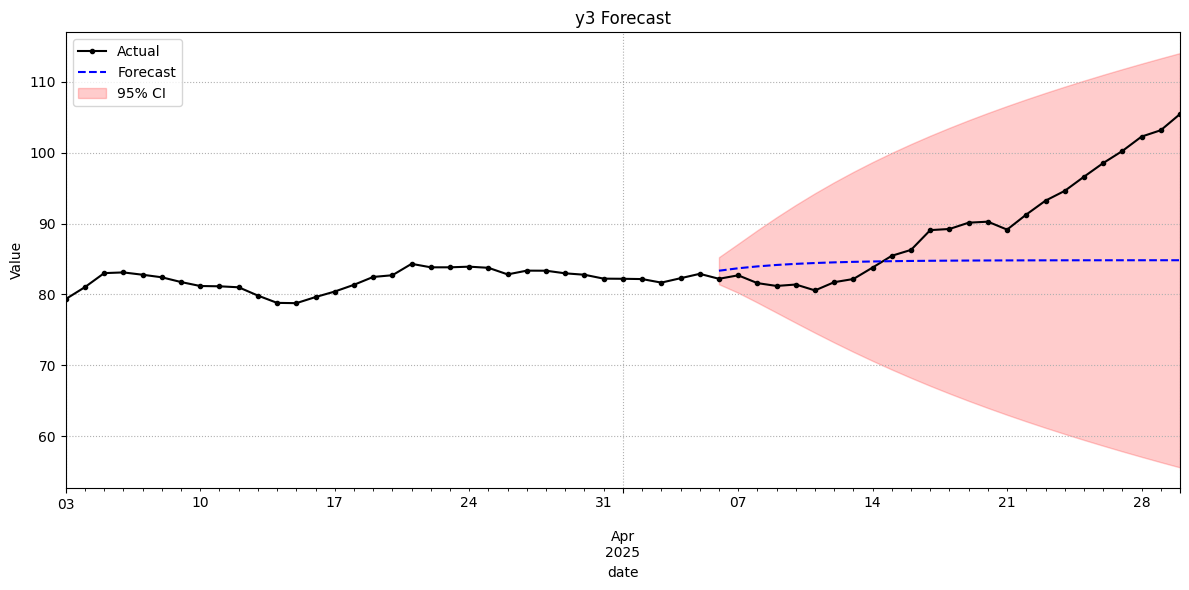

In [78]:
plot_forecast_with_ci('2025-03-03', y3_df, 'y3', 'y3_fore', 'y3_lower', 'y3_upper', 'y3 Forecast')

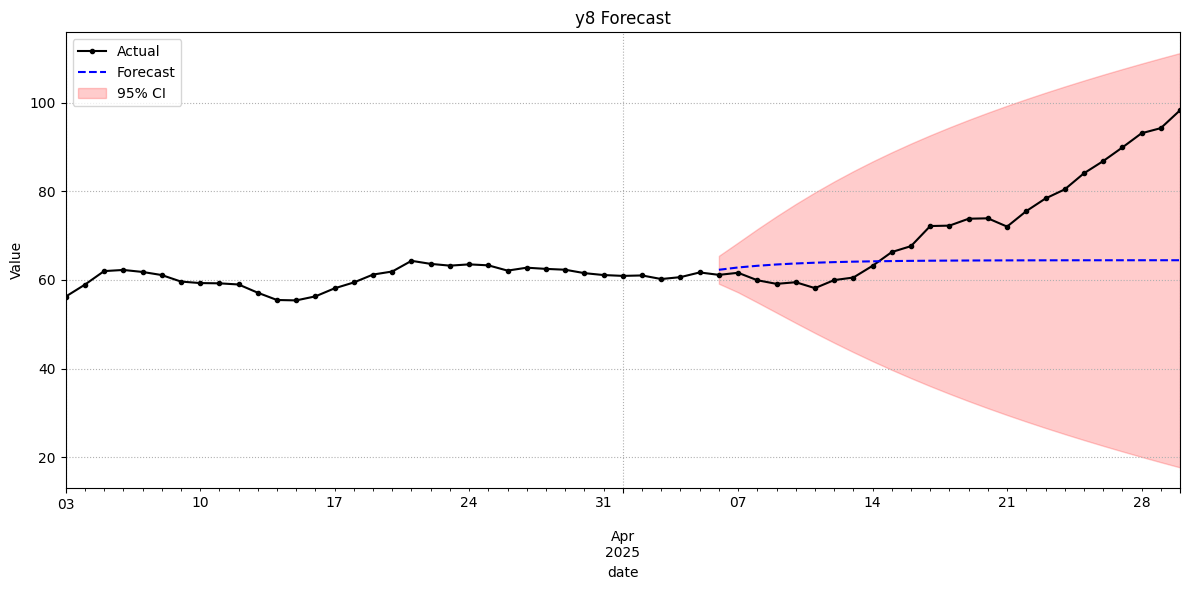

In [79]:
plot_forecast_with_ci('2025-03-03', y8_df, 'y8', 'y8_fore', 'y8_lower', 'y8_upper', 'y8 Forecast')

In [80]:
arima_merged_fcst = df[['y3', 'y8']].merge(pd.concat([y3_forecast_df, y8_forecast_df], axis=1), left_index=True, right_index=True, how='left')

In [81]:
print_accuracy_measures(arima_merged_fcst.dropna(), 3, 'y3', 'y8')

Forecast Accuracy Metrics for 3 lags:
                  y3          y8
MAE         6.746161   11.081293
MSE        80.575640  218.048616
RMSE        8.976393   14.766469
MAPE (%)    7.070127   13.624004
AMAPE (%)   7.477260   15.127674


### Forecasting Competition

Now, as we performed forecasting both for chosen ARIMA models and VECM models we can see which model performs the best. Moreover we can compare obtained point predictions with naive forecast to see whether we managed to improve simple guessing stategy. Note that we did not reestimate our models. Meaning that we simply created 25 periods ahead forecasts. That is why forecasts lines look quite flat. Obviously we use mean reverting processes so without any adjustments for observed values in these 25 periods our proccesses just revert to their means.

Obvious comparison would be then the naive forecast which for each of the 25 time periods takes the same value equal to the last observed value before forecasting period

In [82]:
forecast_dates = df[-25:].index


In [83]:
naive_fcst = pd.DataFrame({
    "y3_fore": [sample_df["y3"].iloc[-1]]*25,
    "y8_fore": [sample_df["y8"].iloc[-1]]*25
},
index=forecast_dates)


In [84]:
naive_fcst_df = df[['y3', 'y8']].merge(naive_fcst, left_index=True, right_index=True, how='left')

In [85]:
print_accuracy_measures(naive_fcst_df.dropna(),3,'y3','y8')

Forecast Accuracy Metrics for 3 lags:
                   y3          y8
MAE          7.564000   12.274000
MSE        103.922896  273.892596
RMSE        10.194258   16.549701
MAPE (%)     7.880164   14.913224
AMAPE (%)    8.445664   16.971104


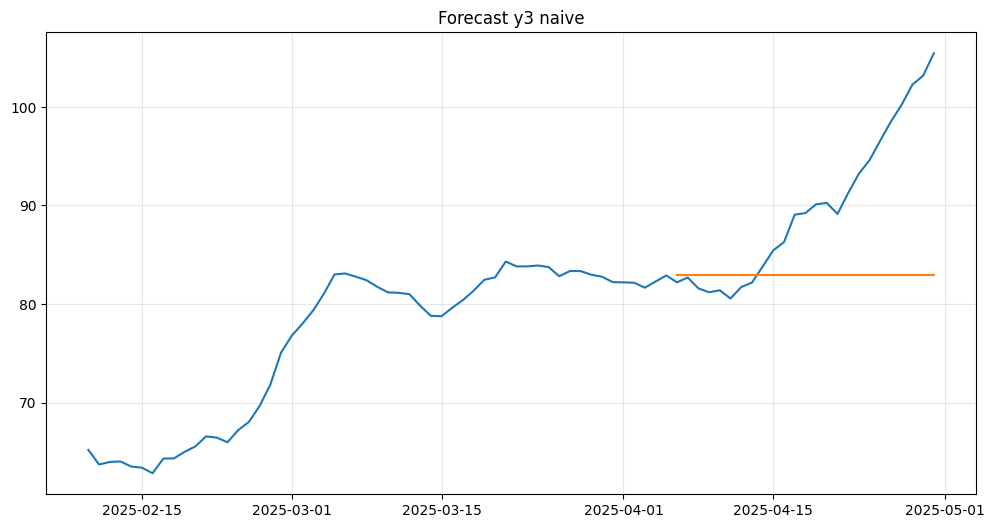

In [86]:
plt.figure(figsize = (12, 6))
plt.plot(df["y3"].iloc[-80:])
plt.plot(naive_fcst_df["y3_fore"])
plt.grid(alpha=0.3)
plt.title("Forecast y3 naive")
plt.show()

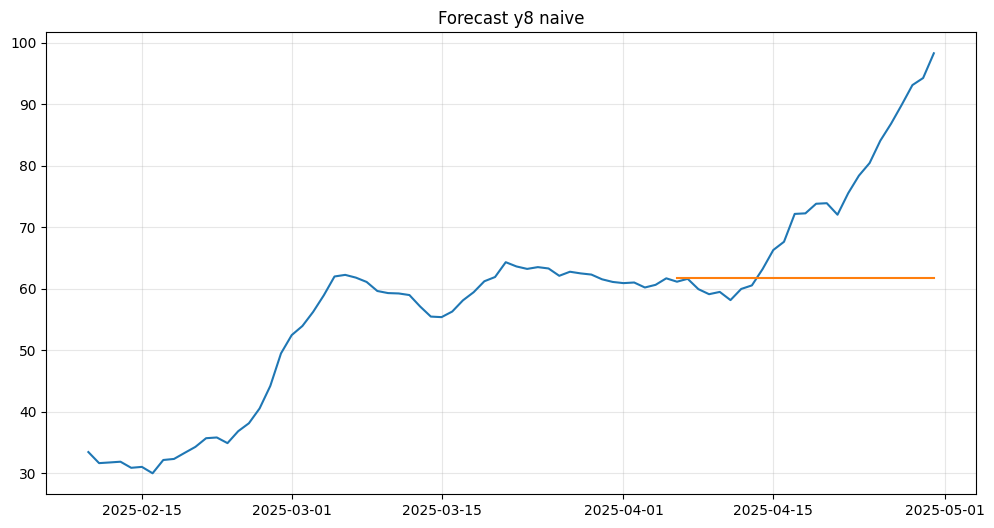

In [87]:
plt.figure(figsize = (12, 6))
plt.plot(df["y8"].iloc[-80:])
plt.plot(naive_fcst_df["y8_fore"])
plt.title("Forecast y8 naive")
plt.grid(alpha = 0.3)
plt.show()

Above we show naive forecast results. Let's now compare all forecasts

In [106]:
arima_metrics = get_accuracy_measures(arima_merged_fcst.dropna(), 3, "y3", "y8")
vecm_metrics = get_accuracy_measures(df_merged.dropna(), 3, "y3", "y8")
naive_metrics = get_accuracy_measures(naive_fcst_df.dropna(), 3, "y3", "y8")

arima_metrics.columns = pd.MultiIndex.from_product([['ARIMA'], arima_metrics.columns])
vecm_metrics.columns = pd.MultiIndex.from_product([['VECM'], vecm_metrics.columns])
naive_metrics.columns = pd.MultiIndex.from_product([['Naive'], naive_metrics.columns])

combined_metrics = pd.concat([arima_metrics, vecm_metrics, naive_metrics], axis=1)

Forecast Accuracy Metrics for 3 lags:
Forecast Accuracy Metrics for 3 lags:
Forecast Accuracy Metrics for 3 lags:


In [108]:
combined_metrics

ARIMA                   VECM                   Naive  \
                  y3          y8         y3          y8          y3   
MAE         6.746161   11.081293   6.563340   10.581120    7.564000   
MSE        80.575640  218.048616  75.908374  195.186893  103.922896   
RMSE        8.976393   14.766469   8.712541   13.970930   10.194258   
MAPE (%)    7.070127   13.624004   6.890769   13.129224    7.880164   
AMAPE (%)   7.477260   15.127674   7.264021   14.383043    8.445664   

                       
                   y8  
MAE         12.274000  
MSE        273.892596  
RMSE        16.549701  
MAPE (%)    14.913224  
AMAPE (%)   16.971104

As can be seen, overall best model is VECM. We also managed to improve results obtained with naive forecast